In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import torch
import random
from IPython import display
from matplotlib import pyplot as plt
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
warnings.filterwarnings("ignore")

In [ ]:
# 定义dataset
class my_Dataset(data.Dataset):
  def __init__(self, features, labels):
    self.X = features
    self.y = labels

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

In [ ]:
class TrafficDataset:
  def __init__(self, sensor=10, target=0):
    # 选取适当的检测器用作序列数据
    self.raw_data = np.load('/content/traffic.npz')['data']
    self.sensor = sensor
    self.target = target
    # 数据标准化
    self.min = self.raw_data.min()
    self.max = self.raw_data.max()
    self.data = (self.raw_data - self.min) / (self.max - self.min)

  def denormalize(self, x):
    return x * (self.max - self.min) + self.min

  def construct_set(self, train_por = 0.6, test_por = 0.2, window_size = 12, label=0):
    # 预测车流量 选取1号传感器，滑动窗口大小设置为12
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    sensor_num = 1

    # 补全构造过程
    #训练集
    len_train = int(self.data.shape[0] * train_por)
    train_seqs = self.data[:len_train]
    for i in range(train_seqs.shape[0] - window_size):
      train_x.append(train_seqs[i:i + window_size, sensor_num, :].squeeze())
      train_y.append(train_seqs[i + window_size, sensor_num, label].squeeze())

    # train_x = torch.Tensor(train_x)
    # train_y = torch.Tensor(train_y)
    #验证集
    len_val = int(self.data.shape[0] * (train_por+test_por))
    val_seqs = self.data[len_train:len_val]
    for i in range(val_seqs.shape[0] - window_size):
      val_x.append(val_seqs[i:i + window_size, sensor_num, :].squeeze())
      val_y.append(val_seqs[i + window_size, sensor_num, label].squeeze())

    # val_x = torch.Tensor(val_x)
    # val_y = torch.Tensor(val_y)
    #测试集
    test_seqs = self.data[len_val:]
    for i in range(test_seqs.shape[0] - window_size):
      test_x.append(test_seqs[i:i + window_size, sensor_num, :].squeeze())
      test_y.append(test_seqs[i + window_size, sensor_num, label].squeeze())

    # test_x = torch.Tensor(test_x)
    # test_y = torch.Tensor(test_y)

    train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
    val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
    test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
    return train_set, val_set, test_set

In [ ]:
def mape_fn(y, pred):
  mask = y != 0
  y = y[mask]
  pred = pred[mask]
  mape = np.abs((y - pred) / y)
  mape = np.mean(mape) * 100
  return mape


def eval(y, pred):
  y = y.cpu().numpy()
  pred = pred.cpu().numpy()
  mse = mse_fn(y, pred)
  rmse = math.sqrt(mse)
  mae = mae_fn(y, pred)
  mape = mape_fn(y, pred)
  return [rmse, mae, mape]


In [ ]:
def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
  x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
  plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
  plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


def plot_metric(score_log):
  score_log = np.array(score_log)

  plt.figure(figsize=(10, 6), dpi=300)
  plt.subplot(2, 2, 1)
  plt.plot(score_log[:, 0], c='#d28ad4')
  plt.ylabel('RMSE')

  plt.subplot(2, 2, 2)
  plt.plot(score_log[:, 1], c='#e765eb')
  plt.ylabel('MAE')

  plt.subplot(2, 2, 3)
  plt.plot(score_log[:, 2], c='#6b016d')
  plt.ylabel('MAPE')

  plt.show()


In [ ]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
class My_GRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
        
    self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
    # 用于计算candidate hidden state
    self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
        
    self.output = nn.Sequential(
      nn.Linear(hidden_size, hidden_size // 2),
      nn.ReLU(),
      nn.Linear(hidden_size // 2, output_size)
    )
            
    for param in self.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)
                
  def forward(self, x):
    batch_size = x.size(0)
    seq_len = x.size(1)
        
    h = torch.zeros(batch_size, self.hidden_size).to(x.device)
    y_list = []
    for i in range(seq_len):
      update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
      update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
      candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
      h = (1-update_gate) * h + update_gate * candidate_hidden
      y_list.append(self.output(h))
    return torch.stack(y_list, dim=1), h

In [ ]:
def mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  non_zero_index = (y_true > 0)
  y_true = y_true[non_zero_index]
  y_pred = y_pred[non_zero_index]

  mape = np.abs((y_true - y_pred) / y_true)
  mape[np.isinf(mape)] = 0
  return np.mean(mape) * 100

In [ ]:
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
  rmse, mae, mape = 0, 0, 0
  batch_count = 0
  total_loss = 0.0
  net.eval()
  if output_model is not None:
    output_model.eval()
  for X, Y in data_iter:
    X = X.to(device).float()
    Y = Y.to(device).float()
    output, hidden = net(X)
    if output_model is not None:
      y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
    else:
      y_hat = output[:, -1, :].squeeze(-1)
    loss = loss_fn(y_hat, Y)

    Y = denormalize_fn(Y)
    y_hat = denormalize_fn(y_hat)
    a, b, c = eval(Y.detach(), y_hat.detach())
    rmse += a
    mae += b
    mape += c
    total_loss += loss.detach().cpu().numpy().tolist()
    batch_count += 1
  return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [ ]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
  train_loss_lst = []
  val_loss_lst = []
  train_score_lst = []
  val_score_lst = []
  epoch_time = []

  best_epoch = 0
  best_val_rmse = 9999
  early_stop_flag = 0
  for epoch in range(num_epoch):
    net.train()
    if output_model is not None:
      output_model.train()
    epoch_loss = 0
    batch_count = 0
    batch_time = []
    rmse, mae, mape = 0, 0, 0
    for X, Y in train_iter:
      batch_s = time.time()
      X = X.to(device).float()
      Y = Y.to(device).float()
      optimizer.zero_grad()
      output, hidden = net(X)
      if output_model is not None:
        y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
      else:
        y_hat = output[:, -1, :].squeeze(-1)
      # print('---------------------------------------------')
      # print(y_hat,Y)
      # print('--------------------------------------------')
      loss = loss_fn(y_hat, Y)
      loss.backward()
      optimizer.step()

      Y = denormalize_fn(Y)
      y_hat = denormalize_fn(y_hat)
      a, b, c = eval(Y.detach(), y_hat.detach())
      rmse += a
      mae += b
      mape += c
      epoch_loss += loss.detach().cpu().numpy().tolist()
      batch_count += 1
      # sample_num += X.shape[0]

      batch_time.append(time.time() - batch_s)
      if is_print and is_print_batch:
        print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %(epoch + 1, batch_count, epoch_loss, batch_time[-1]))

    train_loss = epoch_loss / batch_count
    train_loss_lst.append(train_loss)
    train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

    # 验证集
    val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
    val_score_lst.append(val_score)
    val_loss_lst.append(val_loss)

    epoch_time.append(np.array(batch_time).sum())

    # 打印本轮训练结果
    if is_print:
      print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
          (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 早停
    if val_score[0] < best_val_rmse:
      best_val_rmse = val_score[0]
      best_epoch = epoch
      early_stop_flag = 0
    else:
      early_stop_flag += 1
      if early_stop_flag == early_stop:
        print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
        break

  # 输出最终训练结果
  print(f'\n{"*" * 40}\nFinal result:')
  print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
  print(f'Total time {np.array(epoch_time).sum():.2f}s')
  print()

  # 计算测试集效果
  test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
  print('Test result:')
  print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
  return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
print(input_size)
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

my_rnn = My_GRU(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

3


In [ ]:
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = [], [], [], [], 0
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                          loss_func, TrafficData.denormalize, optimizer, epochs,
                                          early_stop=50, device=device, output_model=None)

*** epoch1, train loss 0.0509, train rmse 235.8970, val loss 0.0045, val rmse 72.938123, time use 6.973s
*** epoch2, train loss 0.0018, train rmse 47.5783, val loss 0.0012, val rmse 39.445006, time use 1.982s
*** epoch3, train loss 0.0009, train rmse 34.6200, val loss 0.0009, val rmse 33.779510, time use 2.030s
*** epoch4, train loss 0.0008, train rmse 31.4042, val loss 0.0009, val rmse 32.675421, time use 2.011s
*** epoch5, train loss 0.0007, train rmse 30.8700, val loss 0.0008, val rmse 32.375864, time use 2.052s
*** epoch6, train loss 0.0007, train rmse 30.6207, val loss 0.0008, val rmse 32.216702, time use 2.052s
*** epoch7, train loss 0.0007, train rmse 30.4348, val loss 0.0008, val rmse 32.050814, time use 2.000s
*** epoch8, train loss 0.0007, train rmse 30.3091, val loss 0.0008, val rmse 32.017225, time use 2.013s
*** epoch9, train loss 0.0007, train rmse 30.0984, val loss 0.0008, val rmse 31.750099, time use 1.985s
*** epoch10, train loss 0.0007, train rmse 30.0284, val loss 0.

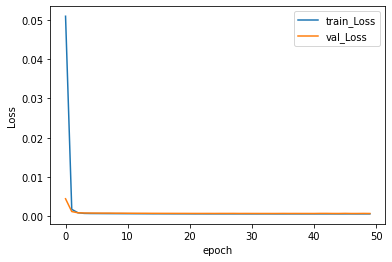

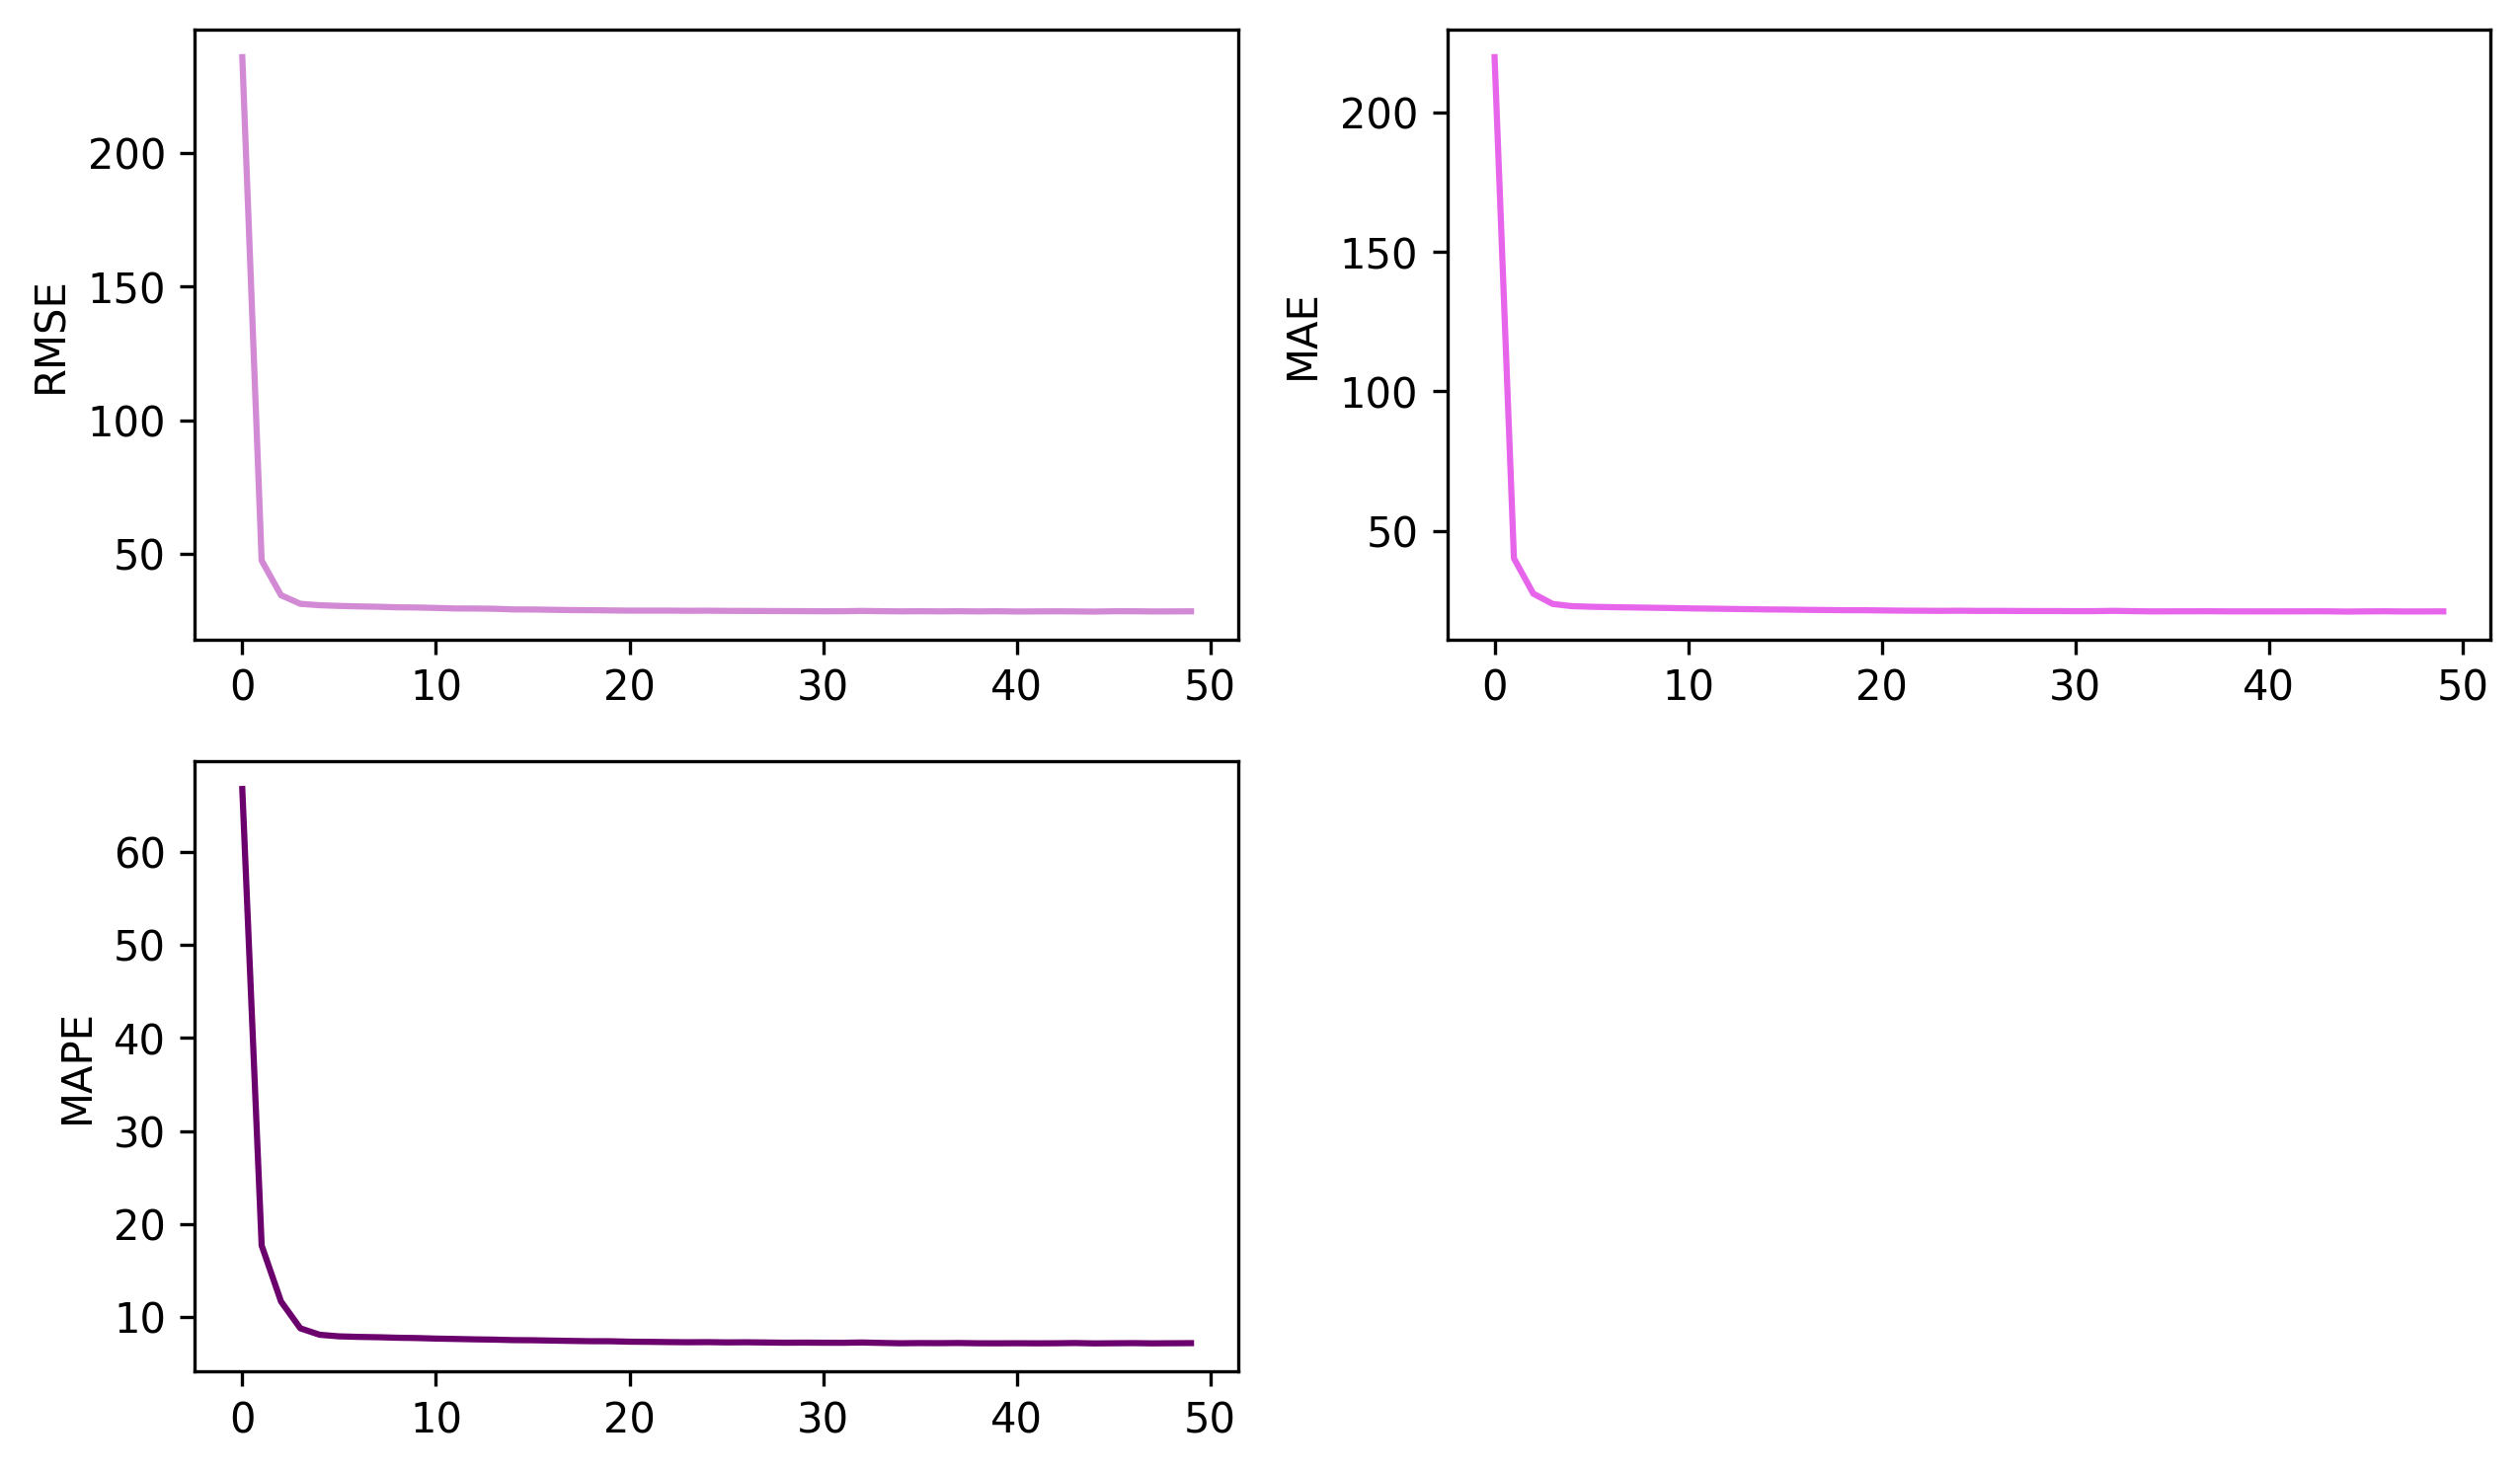

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=50, device=device, output_model=out_linear)

*** epoch1, train loss 0.0995, train rmse 357.5870, val loss 0.0353, val rmse 200.344378, time use 1.327s
*** epoch2, train loss 0.0152, train rmse 139.8146, val loss 0.0120, val rmse 119.215276, time use 0.437s
*** epoch3, train loss 0.0107, train rmse 118.4280, val loss 0.0096, val rmse 106.829183, time use 0.429s
*** epoch4, train loss 0.0081, train rmse 102.9693, val loss 0.0067, val rmse 88.099625, time use 0.423s
*** epoch5, train loss 0.0048, train rmse 79.0281, val loss 0.0032, val rmse 61.664192, time use 0.435s
*** epoch6, train loss 0.0019, train rmse 49.2012, val loss 0.0014, val rmse 40.955550, time use 0.428s
*** epoch7, train loss 0.0011, train rmse 38.3760, val loss 0.0013, val rmse 39.153438, time use 0.429s
*** epoch8, train loss 0.0011, train rmse 37.7533, val loss 0.0013, val rmse 39.066848, time use 0.426s
*** epoch9, train loss 0.0011, train rmse 37.4957, val loss 0.0012, val rmse 38.618430, time use 0.435s
*** epoch10, train loss 0.0011, train rmse 37.1582, val l

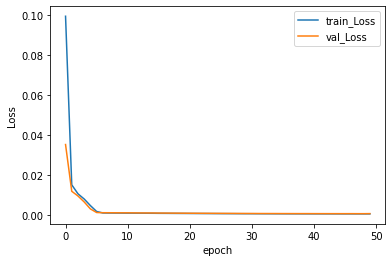

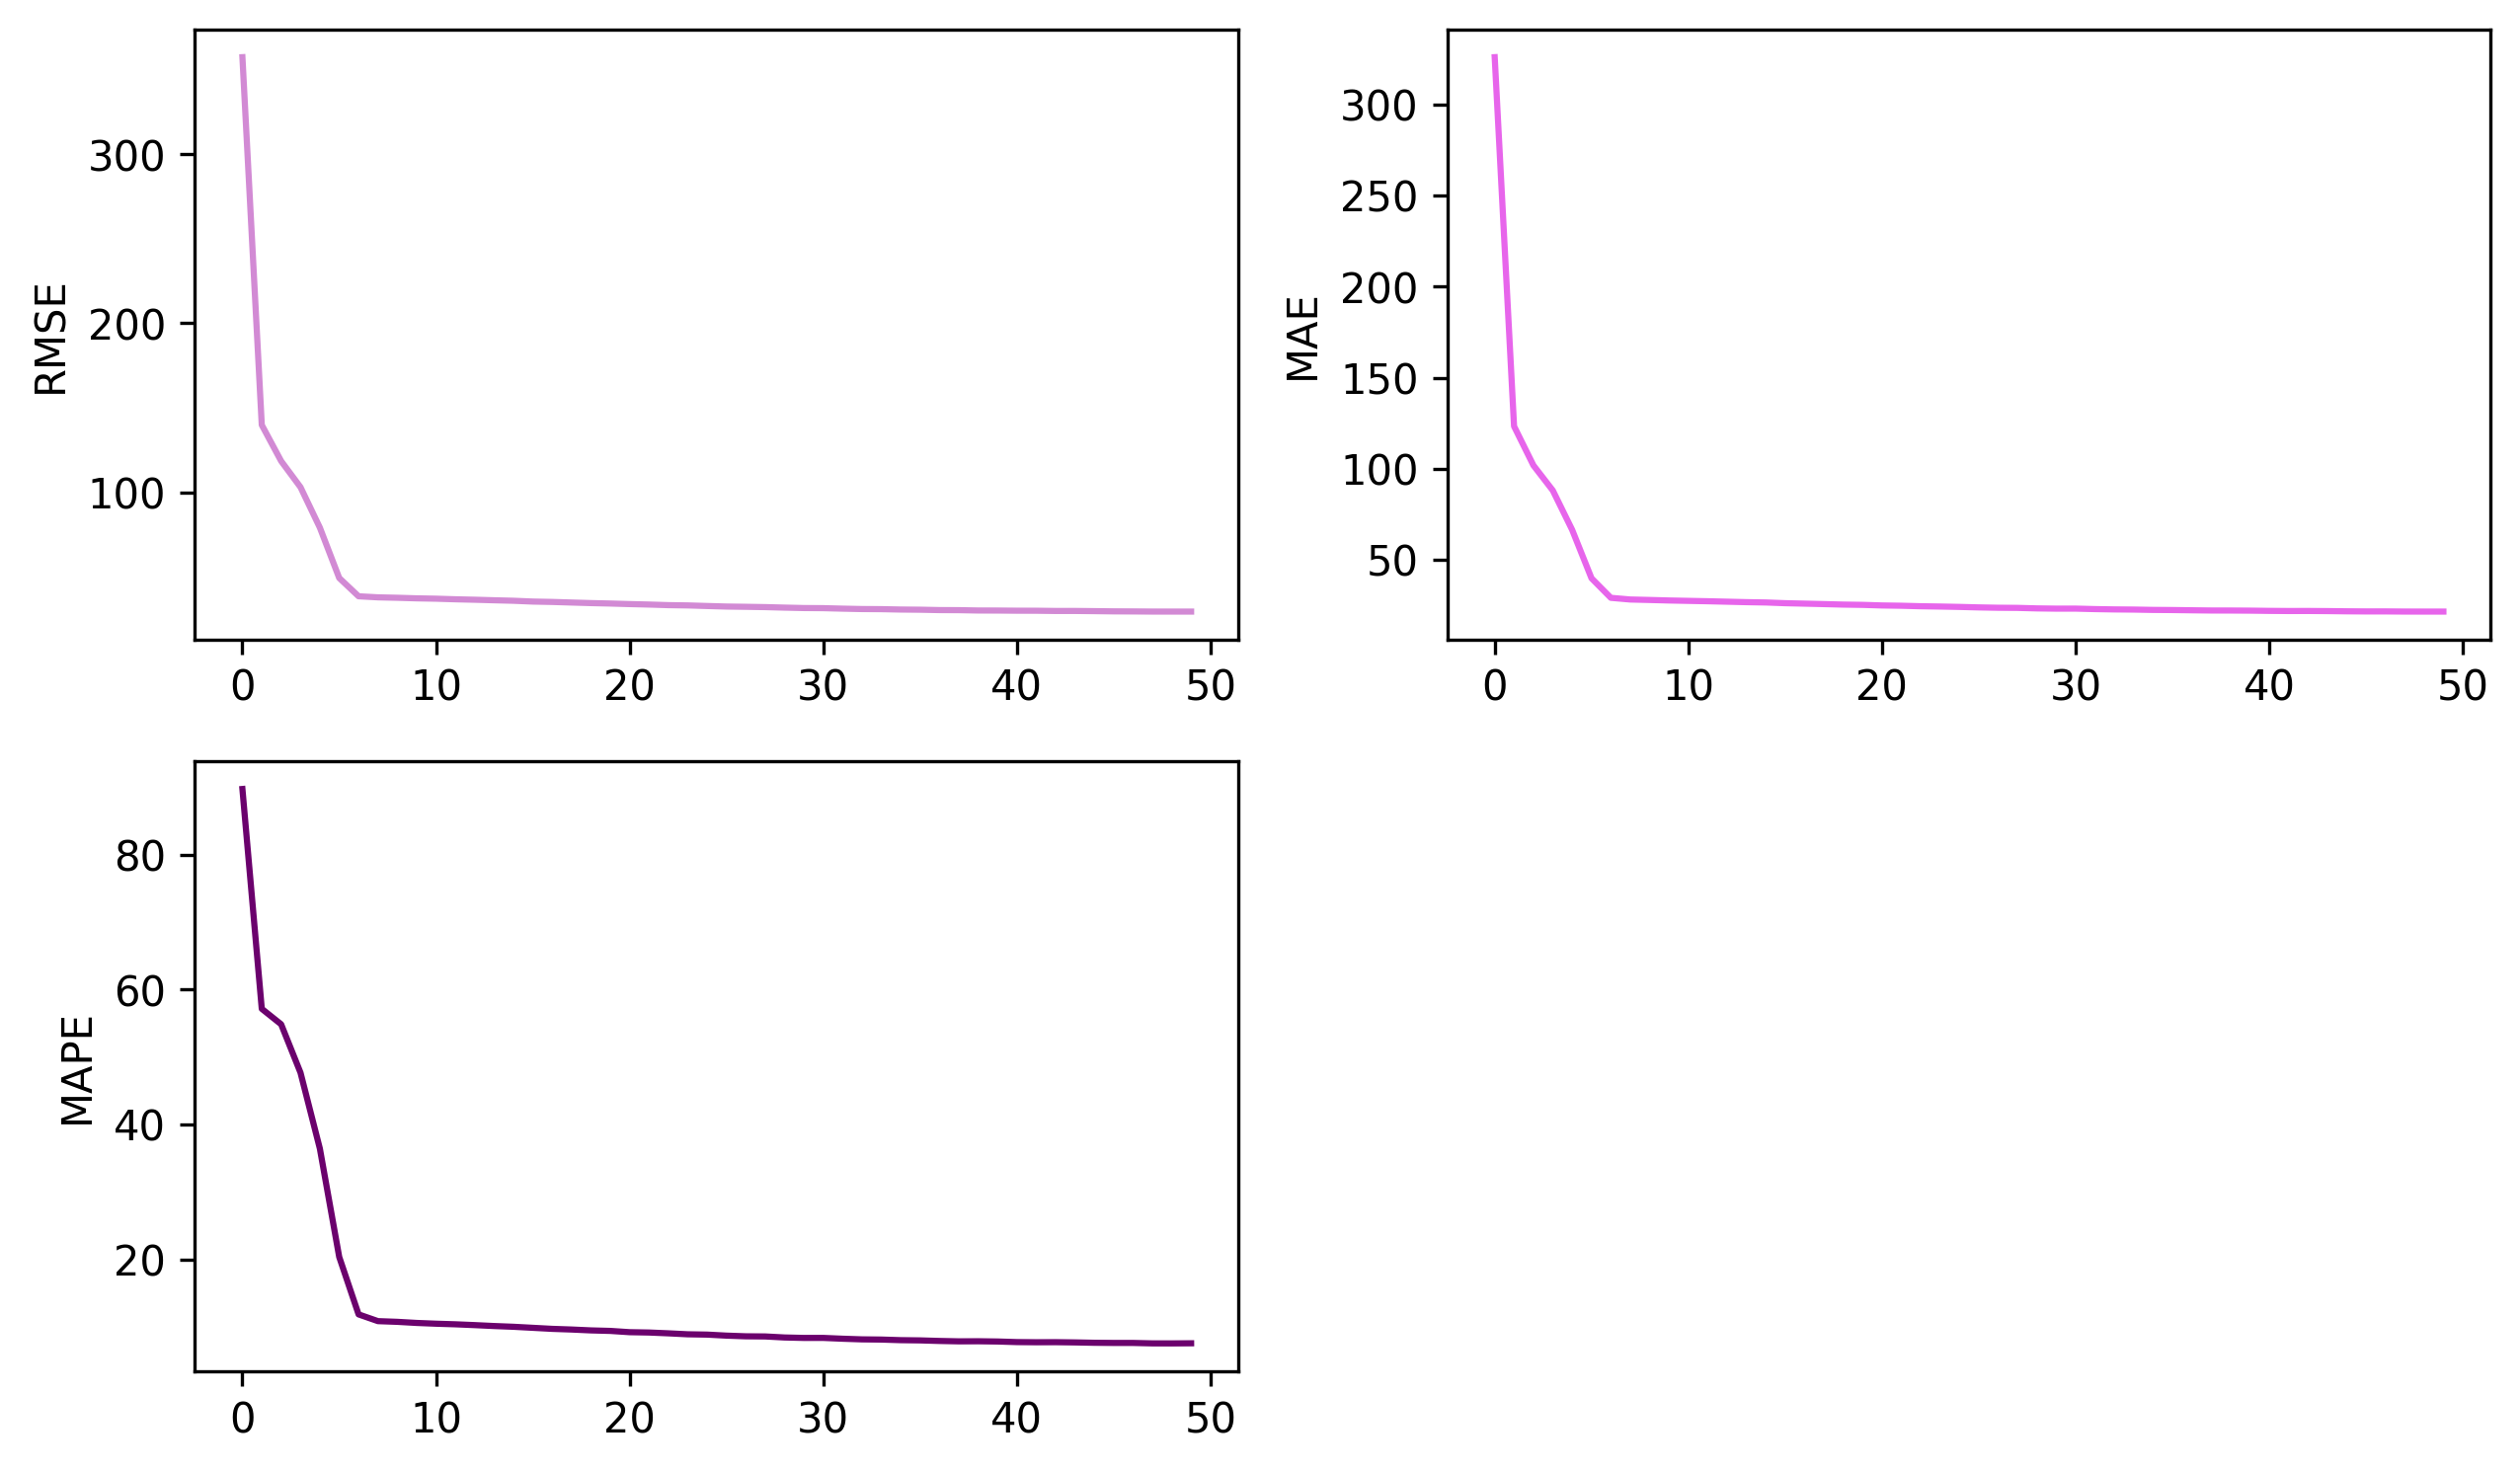

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)